In [1]:
from __future__ import unicode_literals, division

import IPython
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import *
from StringIO import StringIO
from scipy.stats import rankdata
from IPython.display import HTML
from IPython.display import display as prnt

# Notebook Options
%matplotlib inline
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Matplotlib Styles
c = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }
wide_c = dict(c, **{'figure.figsize':[20,8]})
thin_c = dict(c, **{'figure.figsize':[16,8]})

# Source Data
id = '1GnTfMdu9LATsemrfHrnWepsVo-H6oma8AZPXgC7RU1k'
url = 'https://docs.google.com/spreadsheets/d/' + id + '/export?format=csv&id'
r = requests.get(url)
df = pd.read_csv(StringIO(r.content), parse_dates=[u'Timestamp'])

# Episodes
episode_list = df['Episode'].unique()

# Awards
awards = ['Wit','Jockey','Bloodshed','Style','Support']
award_votes = [a[:2]+str(n) for a in awards for n in range(1,4)]
awards_points = [32,16,8]
multiplier = [0.125,0,25,0.5,1,2,4,8]

# Prestige
assassin_prestige_points = 1/16

# Players
id = '1DIVq4s9U_nfY3cHcknGjeV3iGpfW_zxUx-bjFNm4Ebo'
url = 'https://docs.google.com/spreadsheets/d/' + id + '/export?format=csv&id'
r = requests.get(url)
bids = pd.read_csv(StringIO(r.content), parse_dates=[u'Timestamp'])

# Merge in Names
voting_record = df.merge(bids[['Name','Email Address']])

# Data Cleaning
voting_record.columns = ['Timestamp'] + award_votes + ['Email','Episode','Name']
voting_record = voting_record[['Episode','Name'] + award_votes + ['Email','Timestamp']]

# Publication
BASE_URL = 'https://nbviewer.ipython.org/gist/tijptjik/9d99b137b2c30b352d1a/'


# Utility Functions
def table(df,replace_match="",replace_str=""):
    return IPython.display.display(HTML(df.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace(replace_match,replace_str)))

rank = lambda x: rankdata(1/x, method='min')

# HTML Functions
h1 = lambda x : prnt(HTML('''<h1 style="text-align:center">'''+ x +'''</h1>'''))
h2 = lambda x: prnt(HTML('''<h2 style="text-align:center">'''+ x +'''</h2>'''))
h2_success = lambda x: prnt(HTML('''<h2 style="text-align:center" class="alert alert-success">'''+ x +'''</h2>'''))

h3_danger = lambda x: prnt(HTML('''<h3 style="text-align:center" class="alert alert-danger">'''+ x +'''</h3>'''))
h3_info = lambda x: prnt(HTML('''<h3 style="text-align:center" class="alert alert-info">'''+ x +'''</h3>'''))
h3_warning = lambda x: (HTML('''<h3 style="text-align:center" class="alert alert-warning">'''+ x +'''</h3>'''))

h3 = lambda x : prnt(HTML('''<h3 style="text-align:center">'''+ x +'''</h3>'''))
p  = lambda x : prnt(HTML('''<p class="text_cell_render">'''+ x +'''</p>'''))

In [2]:
# DATAFRAMES
import os

fns = os.listdir('.')

get_csvs = lambda x: [fn for fn in fns if fn.startswith(x + '_') & fn.endswith('.csv')]
csv_concat = lambda x: pd.concat([pd.read_csv(fn) for fn in get_csvs(x)], axis=0, ignore_index=True)

# Votes | IDX : [Episode, Player, Award, Points, Character]
votes = csv_concat('votes')
# table(votes)

# Character Score | Character : [Points, Rank]
scores_character = csv_concat('scores_character')
# table(scores_character)

# Character Score | Character : [Points, Rank]
scores_player = csv_concat('scores_player').set_index(['Episode','Multiplier'])
# table(scores_player)

# Performance | Character : [Rating, Rank, Index]
performance = csv_concat('performance')
# table(performance)

# Episodes Aired
h1('ASCENSION | LEADERBOARD')
h2('Game of Thones : Season 5')

In [3]:
HTML('''<script>

code_show=true;

function code_toggle() {
    if (code_show){ 
        $('div.input').hide();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').hide();
    } else {
        $('div.input').show();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').show();
    }
    code_show = !code_show
}
</script>
 
<a class='btn btn-warning btn-lg' style="margin:0 auto; display:block; max-width:320px" href="javascript:code_toggle()">TOGGLE CODE</a>''')

In [4]:
h2_success('EPISODE RECORDS')

links = []
for ep_no, ep in enumerate(episode_list):
    ep_no = str(ep_no+1)
    links.append('''<a href="episode_''' + ep_no + '''.ipynb"><span class="badge badge-info">'''+ ep +'''</span></a>''')
    
prnt(HTML("".join(links)))


h2_success('LEADERBOARD')
h3_info('Score Table')
p('Table of points earned per episode, plus sum of cummulative points earned per player, adjusted for rank')
current_score_table = scores_player.groupby(level=0).sum().T
# score_table.columns = [1,2,3,4,5,6,7,8,9,10]
index = current_score_table.index
columns = range(len(current_score_table.columns),11)
df_ = pd.DataFrame(index=index, columns=columns)
df_ = df_.fillna(0) # with 0s rather than NaNs
score_table =  pd.concat([current_score_table, df_], axis=1)
score_table.columns = range(1,11) + ['Total']
score_table.Total = score_table.T.sum()
score_table['Rank'] = rank(score_table.Total)
score_table = score_table.sort('Rank')
table(score_table)

,1,2,3,4,5,6,7,8,9,10,Total,Rank
Max Ng,681,221,1438,433,348,0,0,0,0,0,3121,1
Hayley,723,782,312,516,30,0,0,0,0,0,2363,2
Jannerah Silverscale,35,73,1638,379,212,0,0,0,0,0,2337,3
Sherin the Sedulous,74,623,20,1520,0,0,0,0,0,0,2237,4
Ivarius Ironsight,630,1073,16,92,193,0,0,0,0,0,2004,5
Mart,274,399,782,519,4,0,0,0,0,0,1978,6
Daisy,29,231,102,1423,0,0,0,0,0,0,1785,7
Dan,111,256,235,382,768,0,0,0,0,0,1752,8
Kent,74,187,8,144,288,0,0,0,0,0,701,9
Josh Du,44,177,56,119,0,0,0,0,0,0,396,10


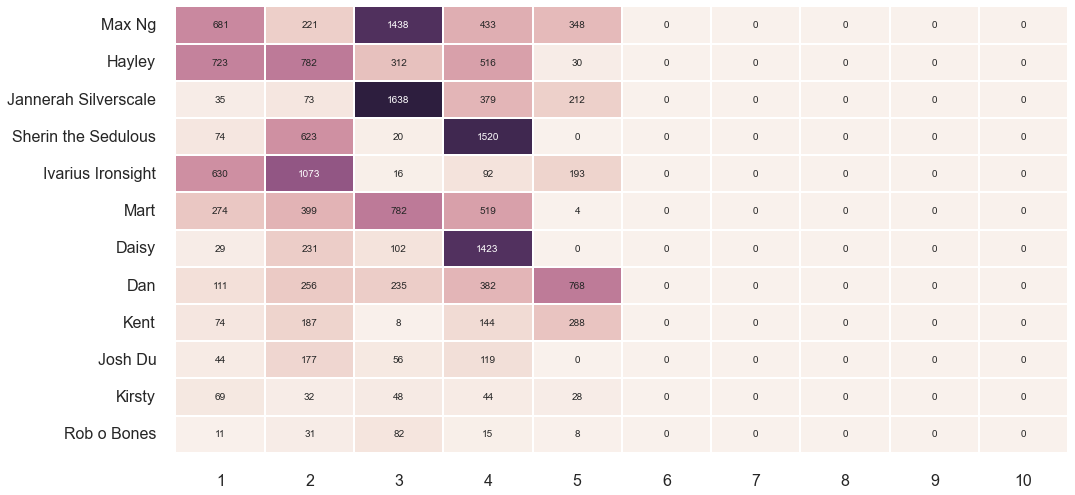

In [5]:
h3_info('Roster Breakdown')
# Searborn Heatmap of cummulative points earned per player, adjusted for rank
with sns.plotting_context("poster", rc=thin_c):
    sns.heatmap(score_table.ix[:,:-2].astype(int64), annot=True, fmt='d', yticklabels=True, annot_kws=None, cbar=False);

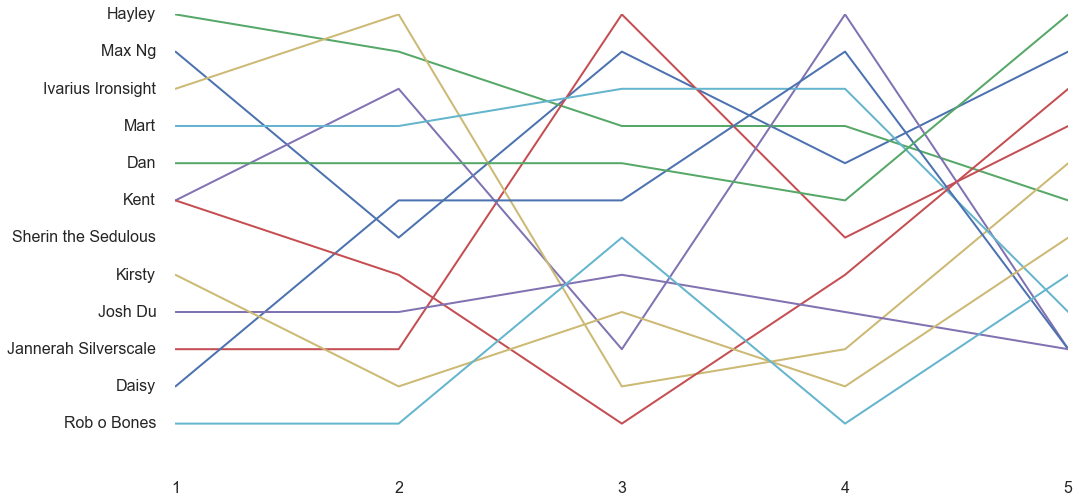

In [6]:
h2_success('POWER METER')
h3_info('Ranking')
p('Line chart tracing the player ranks over season')
power_meter = score_table.copy()
for ep in score_table:
    power_meter[ep] = rank(score_table[ep])
with sns.plotting_context("poster", font_scale=1, rc=thin_c):
    plt.plot(power_meter.ix[:,:len(episode_list)].T)
    plt.gca().invert_yaxis()
    plt.ylim([13,1])
    plt.yticks(arange(1,13), score_table[1].order(ascending=False).index )
    plt.xticks(arange(0,len(episode_list)),power_meter.columns)

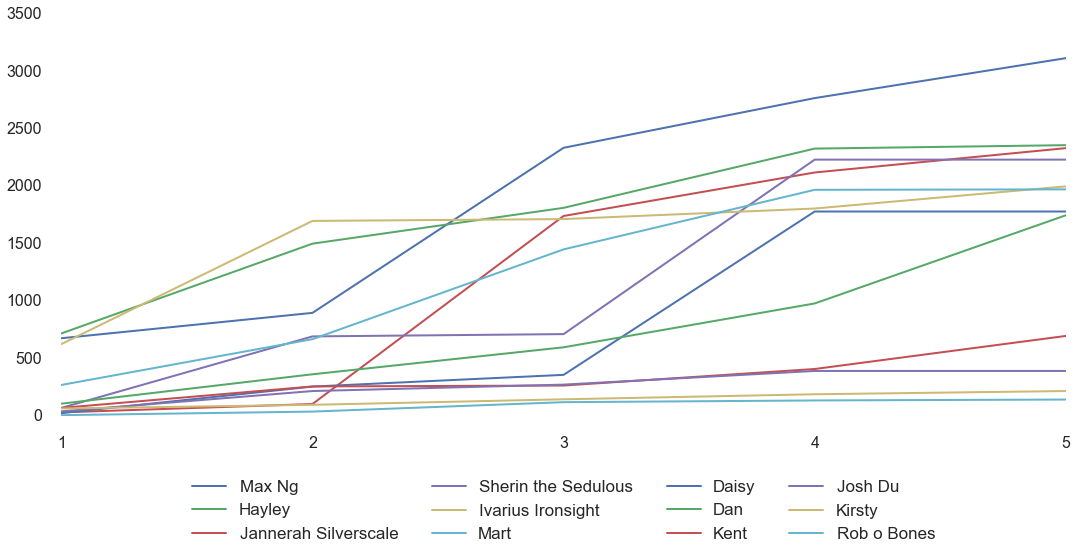

In [7]:
h3_info('Total Points')
p('Line chart tracing the player total points over season')

score_meter = score_table.T
for player in score_meter:
    score_meter.ix[:10, player] = score_meter.ix[:10, player].cumsum()
    
    
with sns.plotting_context("poster", font_scale=1, rc=c):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    for i in xrange(1,13):
        ax.plot(score_meter.index[:len(episode_list)], score_meter.ix[:len(episode_list),i-1], label=score_meter.columns[i-1])

    plt.xticks(arange(1,len(episode_list) + 1), power_meter.columns)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
              fancybox=False, ncol=4)

In [8]:
HTML('''<a class='btn btn-warning btn-lg' style="margin:0 auto; display:block; max-width:320px" href="javascript:code_toggle()">TOGGLE CODE</a>''')

In [9]:
HTML('''<link href='http://fonts.googleapis.com/css?family=Roboto|Open+Sans' rel='stylesheet' type='text/css'>
<script>$(function(){$('.table *').css('text-align','center');
$('body').css('font-family', "'Open Sans','Source Sans Pro','Proxima Nova', sans-serif");$('h1,h2,h3,h4,h5').css('font-family', "'Roboto','Source Sans Pro','Proxima Nova', sans-serif");
$('.table, .table *').css('border',0)})</script>''')

In [10]:
HTML('''
<link href='http://fonts.googleapis.com/css?family=Roboto|Open+Sans' rel='stylesheet' type='text/css'>
<style>
body #notebook {
    font-family : 'Open Sans','Source Sans Pro','Proxima Nova', sans-serif;
    line-height: 1.4em;
    font-size: 1.2em;
    padding: 0 32px;
    line-height: 1.8em;
}

#notebook h1,
#notebook h2,
#notebook h3,
#notebook h4,
#notebook h5 {
    font-family : 'Roboto','Source Sans Pro','Proxima Nova', sans-serif;
}


#notebook .panel-body {
  font-size: 1.1em;
  line-height: 1.6em;
}

#notebook .table,
#notebook .table th,
#notebook .table td,
#notebook .table tr {
    text-align : center;
    border: 0;
    font-size: 1.5rem;
    line-height: 2.2rem
}


.badge {
  padding: 6px 14px 6px;
  font-size: 16px;
  font-weight: bold;
  white-space: nowrap;
  color: #ffffff;
  background-color: #999999;
  -webkit-border-radius: 12px;
  -moz-border-radius: 12px;
  border-radius: 16px;
  margin: 4px;
  line-height: 1.4em;
}
.badge:hover {
  color: #ffffff;
  text-decoration: none;
  cursor: pointer;
}
.badge-error {
  background-color: #b94a48;
}
.badge-error:hover {
  background-color: #953b39;
}
.badge-warning {
  background-color: #f89406;
}
.badge-warning:hover {
  background-color: #c67605;
}
.badge-success {
  background-color: #468847;
}
.badge-success:hover {
  background-color: #356635;
}
.badge-info {
  background-color: #3a87ad;
}
.badge-info:hover {
  background-color: #2d6987;
}
.badge-inverse {
  background-color: #333333;
}
.badge-inverse:hover {
  background-color: #1a1a1a;
}
</style>

<script>
$(function(){
    code_toggle()
    $('#notebook-container > b').contents().unwrap();
})
</script>
''')